In [55]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications import EfficientNetB7, ResNet50, ResNet152
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow import convert_to_tensor
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

In [4]:
dataset_path = 'C:\\Users\\asimw\\Downloads\\Final exam dataset-20230107T074054Z-001\\Final exam dataset'

In [6]:
classes = os.listdir(dataset_path)
classes

['0-AK', '1-BCC', '2-BKL', '3-DF', '4-MEL', '5-NV', '6-SCC', '7-VASC']

Loading Data

In [7]:
#The image paths for all the classes
image_paths = []
images = []
#Respective labels for the images. Labels are not one hot encoded
labels = []
for folder in classes:
  folder_path = os.path.join(dataset_path, folder)
  img_paths = os.listdir(folder_path)
  image_paths = image_paths + [os.path.join(folder_path, img) for img in img_paths]
  labels = labels +  [classes.index(folder)] * len(img_paths)

In [8]:
#Image Dimensions for loading
IMAGE_WIDTH = 400
IMAGE_HEIGHT = 400

In [9]:
for path in image_paths:
  img = cv2.imread(path)
  img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
  images.append(img)

In [10]:
len(image_paths), len(labels), len(images)

(1397, 1397, 1397)

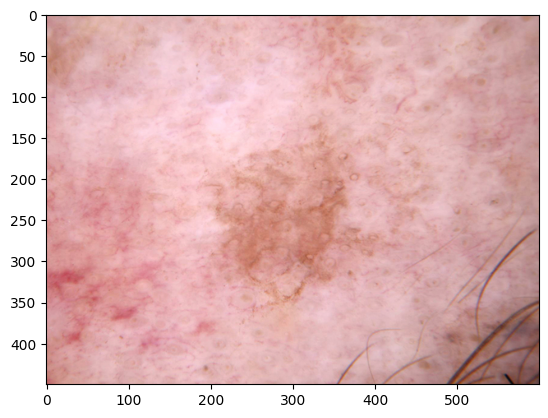

In [11]:
#Displaying an image
img = plt.imread(image_paths[10])
plt.imshow(img, cmap='gray')

In [12]:
#Image Dimensions
img.shape

(450, 600, 3)

Shuffling and Splitting Dataset to train and test

In [13]:
X, Y = shuffle(images, labels, random_state = 402)
X = np.array(X)
Y = np.array(Y)

In [ ]:
X = X / 255.

In [14]:
print(X.shape, Y.shape)

(1397, 400, 400, 3) (1397,)


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 123, test_size = 0.2)

In [16]:
print(X_train.shape, Y_train.shape)

(1117, 400, 400, 3) (1117,)


In [17]:
print(X_test.shape, Y_test.shape)

(280, 400, 400, 3) (280,)


Creating Image Generator to Load Images while running

In [18]:
def generator(X, Y, epochs, steps_per_epoch, batch_size = 32):
  for j in range(epochs):
    for i in range(steps_per_epoch):
      indexes = np.random.choice(len(X), batch_size)
      x = []
      y = []
      for index in indexes:
        img = cv2.imread(X[index])
        img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        img = img / 255.0
        x.append(img)
        y.append(Y[index])
      x = convert_to_tensor(x, dtype='float32')
      y = convert_to_tensor(y, dtype = 'int32')
      yield (x, y)

# Model Building

In [38]:
loaded_model = ResNet152(include_top=False, weights = 'imagenet', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

In [39]:
for layer in loaded_model.layers:
  layer.trainable = False

In [40]:
x = Flatten()(loaded_model.output)
x = Dense(len(classes), activation = 'softmax')(x)

model = Model(loaded_model.input, x)
model.compile(optimizer = Adam(0.0001, 0.9), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [41]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 406, 406, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 200, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

 conv2_block2_add (Add)         (None, 100, 100, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 100, 100, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 100, 100, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 100, 100, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 50, 50, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 50, 50, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 50, 50, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 50, 50, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

 conv3_block5_add (Add)         (None, 50, 50, 512)  0           ['conv3_block4_out[0][0]',       
                                                                  'conv3_block5_3_bn[0][0]']      
                                                                                                  
 conv3_block5_out (Activation)  (None, 50, 50, 512)  0           ['conv3_block5_add[0][0]']       
                                                                                                  
 conv3_block6_1_conv (Conv2D)   (None, 50, 50, 128)  65664       ['conv3_block5_out[0][0]']       
                                                                                                  
 conv3_block6_1_bn (BatchNormal  (None, 50, 50, 128)  512        ['conv3_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 25, 25, 256)  131328      ['conv3_block8_out[0][0]']       
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 25, 25, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 25, 25, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 25, 25, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block3_add (Add)         (None, 25, 25, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 25, 25, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 25, 25, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 25, 25, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block6_add (Add)         (None, 25, 25, 1024  0           ['conv4_block5_out[0][0]',       
                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 25, 25, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 25, 25, 256)  262400      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv4_blo

 conv4_block9_3_bn (BatchNormal  (None, 25, 25, 1024  4096       ['conv4_block9_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block9_add (Add)         (None, 25, 25, 1024  0           ['conv4_block8_out[0][0]',       
                                )                                 'conv4_block9_3_bn[0][0]']      
                                                                                                  
 conv4_block9_out (Activation)  (None, 25, 25, 1024  0           ['conv4_block9_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block10_1_conv (Conv2D)  (None, 25, 25, 256)  262400      ['conv4_block9_out[0][0]']       
          

                                                                                                  
 conv4_block12_3_bn (BatchNorma  (None, 25, 25, 1024  4096       ['conv4_block12_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block12_add (Add)        (None, 25, 25, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_bn[0][0]']     
                                                                                                  
 conv4_block12_out (Activation)  (None, 25, 25, 1024  0          ['conv4_block12_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_blo

                                )                                                                 
                                                                                                  
 conv4_block15_3_bn (BatchNorma  (None, 25, 25, 1024  4096       ['conv4_block15_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block15_add (Add)        (None, 25, 25, 1024  0           ['conv4_block14_out[0][0]',      
                                )                                 'conv4_block15_3_bn[0][0]']     
                                                                                                  
 conv4_block15_out (Activation)  (None, 25, 25, 1024  0          ['conv4_block15_add[0][0]']      
                                )                                                                 
          

 conv4_block18_3_conv (Conv2D)  (None, 25, 25, 1024  263168      ['conv4_block18_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block18_3_bn (BatchNorma  (None, 25, 25, 1024  4096       ['conv4_block18_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block18_add (Add)        (None, 25, 25, 1024  0           ['conv4_block17_out[0][0]',      
                                )                                 'conv4_block18_3_bn[0][0]']     
                                                                                                  
 conv4_block18_out (Activation)  (None, 25, 25, 1024  0          ['conv4_block18_add[0][0]']      
          

                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, 25, 25, 1024  263168      ['conv4_block21_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block21_3_bn (BatchNorma  (None, 25, 25, 1024  4096       ['conv4_block21_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block21_add (Add)        (None, 25, 25, 1024  0           ['conv4_block20_out[0][0]',      
                                )                                 'conv4_block21_3_bn[0][0]']     
                                                                                                  
 conv4_blo

 on)                                                                                              
                                                                                                  
 conv4_block24_3_conv (Conv2D)  (None, 25, 25, 1024  263168      ['conv4_block24_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block24_3_bn (BatchNorma  (None, 25, 25, 1024  4096       ['conv4_block24_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block24_add (Add)        (None, 25, 25, 1024  0           ['conv4_block23_out[0][0]',      
                                )                                 'conv4_block24_3_bn[0][0]']     
          

 conv4_block27_2_relu (Activati  (None, 25, 25, 256)  0          ['conv4_block27_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block27_3_conv (Conv2D)  (None, 25, 25, 1024  263168      ['conv4_block27_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block27_3_bn (BatchNorma  (None, 25, 25, 1024  4096       ['conv4_block27_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block27_add (Add)        (None, 25, 25, 1024  0           ['conv4_block26_out[0][0]',      
          

                                                                                                  
 conv4_block30_2_relu (Activati  (None, 25, 25, 256)  0          ['conv4_block30_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block30_3_conv (Conv2D)  (None, 25, 25, 1024  263168      ['conv4_block30_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block30_3_bn (BatchNorma  (None, 25, 25, 1024  4096       ['conv4_block30_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_blo

 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 25, 25, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_3_conv (Conv2D)  (None, 25, 25, 1024  263168      ['conv4_block33_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block33_3_bn (BatchNorma  (None, 25, 25, 1024  4096       ['conv4_block33_3_conv[0][0]']   
 lization)                      )                                                                 
          

 conv4_block36_2_bn (BatchNorma  (None, 25, 25, 256)  1024       ['conv4_block36_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block36_2_relu (Activati  (None, 25, 25, 256)  0          ['conv4_block36_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block36_3_conv (Conv2D)  (None, 25, 25, 1024  263168      ['conv4_block36_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block36_3_bn (BatchNorma  (None, 25, 25, 1024  4096       ['conv4_block36_3_conv[0][0]']   
 lization)

 ization)                                                                                         
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 13, 13, 512)  0          ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 13, 13, 512)  2359808     ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_2_bn (BatchNormal  (None, 13, 13, 512)  2048       ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

In [42]:
from keras.preprocessing.image import ImageDataGenerator

In [43]:
#Basic Parameters
epochs = 15
batch_size = 32
steps_per_epoch = len(X_train) // batch_size

In [44]:
train_gen = ImageDataGenerator(featurewise_center= True, featurewise_std_normalization= True, width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True, vertical_flip = True)
train_gen.fit(X_train)
train_gen = train_gen.flow(X_train, Y_train)

Training Model

In [45]:
history = model.fit(train_gen, epochs = epochs, validation_data = (X_test, Y_test))

Epoch 1/15
35/35 [==============================] - 523s 15s/step - loss: 7.2062 - accuracy: 0.1853 - val_loss: 7.9388 - val_accuracy: 0.1750
Epoch 2/15
35/35 [==============================] - 530s 15s/step - loss: 2.7155 - accuracy: 0.3277 - val_loss: 8.0197 - val_accuracy: 0.2250
Epoch 3/15
35/35 [==============================] - 542s 16s/step - loss: 2.3417 - accuracy: 0.3447 - val_loss: 8.0639 - val_accuracy: 0.2429
Epoch 4/15
35/35 [==============================] - 531s 15s/step - loss: 2.1848 - accuracy: 0.3760 - val_loss: 10.8260 - val_accuracy: 0.1857
Epoch 5/15
35/35 [==============================] - 537s 15s/step - loss: 2.3502 - accuracy: 0.3697 - val_loss: 10.1942 - val_accuracy: 0.2607
Epoch 6/15
35/35 [==============================] - 536s 15s/step - loss: 2.1917 - accuracy: 0.3850 - val_loss: 9.9368 - val_accuracy: 0.2714
Epoch 7/15
35/35 [==============================] - 539s 15s/step - loss: 2.1552 - accuracy: 0.3948 - val_loss: 11.9184 - val_accuracy: 0.2429
Epo

In [46]:
 history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

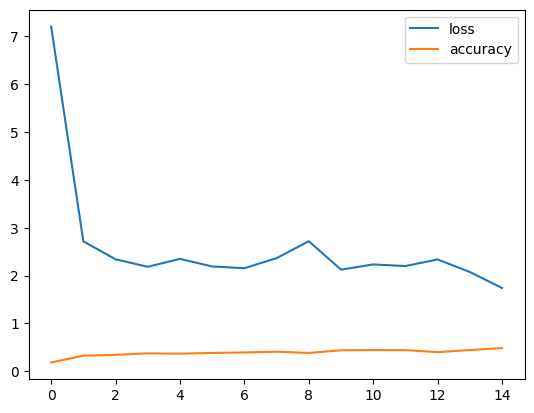

In [47]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.legend()
plt.show()

In [48]:
model.save("Model3.h5")

In [50]:
y_pred = model.predict(X_test)

9/9 [==============================] - 115s 12s/step


In [52]:
y_preds = np.argmax(y_pred, axis = 1)
y_preds

array([5, 0, 1, 1, 1, 5, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 4, 1, 5, 1, 1, 1, 1, 1, 0, 0, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1, 5,
       1, 1, 0, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 0, 5, 1, 0, 0, 1, 5, 0, 1,
       0, 1, 5, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 0, 1, 1,
       5, 1, 1, 5, 1, 1, 1, 0, 1, 5, 5, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 5, 1, 1, 1, 1, 5, 1, 5, 4, 5, 1, 1, 5, 1, 1, 1, 1, 1, 1,
       5, 1, 4, 0, 4, 1, 1, 1, 1, 1, 5, 1, 1, 5, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 5, 1, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, 1, 1, 5, 1, 1, 1,
       5, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 5,
       1, 1, 1, 5, 1, 1, 5, 1, 1, 4, 0, 1, 1, 1, 1, 5, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 5, 1, 1, 1, 1, 5, 5, 5, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [56]:
cm = confusion_matrix(Y_test, y_preds)
cm

array([[ 9, 40,  0,  0,  0,  1,  0,  0],
       [ 1, 39,  1,  0,  0,  3,  0,  0],
       [ 0, 33,  1,  0,  1,  5,  0,  0],
       [ 1, 18,  0,  0,  1,  2,  0,  0],
       [ 1, 20,  1,  0,  5,  4,  0,  0],
       [ 4, 17,  0,  0,  1, 21,  0,  0],
       [ 1, 29,  0,  0,  0,  1,  0,  0],
       [ 6, 12,  0,  0,  0,  1,  0,  0]], dtype=int64)

In [57]:
import seaborn as sns

<AxesSubplot: >

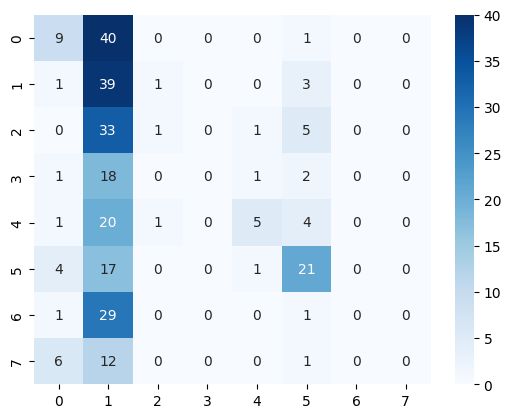

In [58]:
sns.heatmap(cm, annot=True, cmap='Blues')